<a href="https://colab.research.google.com/github/dmitryglhf/jupyter-projects/blob/main/Lab333_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ данных по недвижимости в Португалии

Этот ноутбук выполняет анализ данных по недвижимости в Португалии, исследует влияющие на цену факторы и использует линейную регрессию для предсказания цены.



## 1. Введение

### 1.1 Импортирование библиотек

In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import zscore

from catboost import CatBoostRegressor

###1.2 Загрузка и осмотр изначального датасета

Исходный датасет доступен по ссылке: [Portugal Real Estate](https://www.kaggle.com/datasets/luvathoms/portugal-real-estate-2024)

In [ ]:
url = "https://raw.githubusercontent.com/dmitryglhf/jupyter-projects/main/Maths/lab3/portugal_housing.csv"
df = pd.read_csv(url)
df.head()

###1.3 Получение рабочего датасета

На этом этапе исходный датасет преобразуется к рабочему последовательно:

1.   Удаляется столбец **Type**, так как рассматриваем только квартиры
2.   Из полученной таблицы удаляются строки с отсутствующими ценами
3.   Для полученной таблицы устанавливается пороговое значение 70% и из нее удаляются столбцы, в которых пропущено $>$ 70% (>26201), так как при таком количестве пропусков восстановленные данные будут нереалистичными



In [ ]:
df = df[df['Type'] == 'Apartment']
df = df.drop('Type', axis=1)
df.dropna(subset='Price', inplace=True)
df

In [ ]:
df.isnull().sum()

In [ ]:
columns_to_drop = ['GrossArea', 'PublishDate', 'ConservationStatus', 'LotSize', 'BuiltArea']
df = df.drop(columns_to_drop, axis=1)

**В результате** получили рабочий датасет df

## 2. Первоначальная эффективность модели (dfl)

### 2.1 Подготовка датасета к обучению

На этом этапе происходит последовательная подготовка датасета df к датасету dfl, на котором будет обучаться модель линейной регрессии:

1.   Уменьшается пороговое значение с 70% до 60% и из датасета удаляются столбцы, в которых пропущено $>$ 60% (> 22458), чтобы сохранить как можно больше строк: если мы удалим мало столбцов с большим количесвтом NaN, то функция dropna удалит много строк.
2.   Удаляются строки, в которых есть NaN
3.   В полученной таблице перекодируются строковые признаки в числовые



In [ ]:
columns_to_drop = [ 'Garage', 'Elevator', \
                   'ElectricCarsCharging', 'NumberOfWC', 'NumberOfBedrooms']
dfl = df.drop(columns_to_drop, axis=1)
dfl.dropna(inplace=True)
df.isnull().sum()

In [ ]:
object_columns = ['Floor','District', 'City', 'Town', 'EnergyCertificate', 'Lift', 'HasParking']
for column in object_columns:
  codes, uniqies = pd.factorize(dfl[column])
  dfl[column] = codes

### 2.2 Обучение модели линейной регресии на необработанных данных и оценка показателей эффективности



1.   Разделили датасет на тренировочный и тестовый наборы
2.   Вычислили показатели эффективности обучения модели линейной регрессии на необработанных данных



In [ ]:
X = dfl.drop('Price', axis=1)
y = dfl.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred, squared=False))

Результат получился довольно плохим, судя по R-square, мы решили попробовать обучить модель CatBoost, чтобы оценить обучаемость моделей на наших тренировочных данных

### 2.3 Обучение модели CatBoost на необработанных данных для проверки обучаемости и оценка показателей эффективности R-square, RMSE

In [ ]:
model = CatBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Learning rate set to 0.060944
0:	learn: 315653.7561729	total: 15.5ms	remaining: 15.5s
1:	learn: 305304.4235987	total: 23.2ms	remaining: 11.6s
2:	learn: 296056.8219583	total: 28.5ms	remaining: 9.48s
3:	learn: 286191.4187467	total: 33.5ms	remaining: 8.34s
4:	learn: 278486.0800815	total: 38.8ms	remaining: 7.72s
5:	learn: 270364.3726770	total: 44.5ms	remaining: 7.37s
6:	learn: 264247.3544774	total: 49.7ms	remaining: 7.05s
7:	learn: 256898.4205240	total: 54.8ms	remaining: 6.8s
8:	learn: 250204.3321977	total: 59.8ms	remaining: 6.59s
9:	learn: 243723.9554056	total: 65.9ms	remaining: 6.52s
10:	learn: 238589.3323409	total: 71ms	remaining: 6.38s
11:	learn: 233777.1581555	total: 76.6ms	remaining: 6.31s
12:	learn: 229309.7372636	total: 84.1ms	remaining: 6.39s
13:	learn: 224796.3934630	total: 92.4ms	remaining: 6.51s
14:	learn: 220402.8164083	total: 97.2ms	remaining: 6.38s
15:	learn: 216116.3078975	total: 101ms	remaining: 6.2s
16:	learn: 212239.3027879	total: 107ms	remaining: 6.17s
17:	learn: 208928

In [ ]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred, squared=False))

0.828156108036235
126546.02851418211


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Получили, что показатель эффективности R-square модели CatBoost получился близким к 1, поэтому данная модель дает хороший результат на датасете dfl!

## 3. Анализ одномерных данных


### 3.1 Подготовка датасета к обработке данных (первоначальная обработка $NaN$, перекодировка) (dfu)



На этом этапе происходит последовательная подготовка рабочего датасета df к датасету dfu, который будем обрабатывать:

1.   0 в **NumberOfWC**, **NumberOfBathrooms**, **TotalArea**, **LivingArea**, **TotalRooms** заменяются на  NaN
1.   Теперь снова удаляются столбцы, в которых пропущено $>$ 70% (>26201)
2.   Столбцы **Lift** и **Elevator** соединяются в один столбец **Lift or Elevator**, так как мы заметили (см. код), что эти столбцы взаимно дополняют друг друга и несут информацию об одном и том же: в строке, где $NaN$ в **Lift**, есть значение в **Elevator** и наоборот
2.   Удаляются столбцы **Lift** и **Elevator**
3.   Пропущенные значения столбца **HasParking**, которые говорят о наличии парковочного места, заполняются по значениям столбца **Parking**, которые говорят о количестве парковочных мест.
4.   $NaN$ в столбце **ElectricCarsCharging** заменяются на $False$
5.   Перекодируются строковые признаки в числовые






In [ ]:
dfu = df.copy(deep=True)

In [ ]:
#Заменяем 0 на NaN в указанных столбцах
columns_to_replace = ['NumberOfWC', 'NumberOfBathrooms', 'TotalArea', 'LivingArea', 'TotalRooms']
dfu[columns_to_replace] = dfu[columns_to_replace].replace(0, np.nan)

In [ ]:
dfu.isnull().sum()

,0
Price,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,13893
Lift,13871
Parking,19
HasParking,13871
ConstructionYear,7792


In [ ]:
columns_to_drop = ['NumberOfWC']
dfu = dfu.drop(columns_to_drop, axis=1)

In [ ]:
a=df.Lift * df.Elevator
a.value_counts()

,count


In [ ]:
dfu['Lift or Elevator'] = dfu.Lift | dfu.Elevator

In [ ]:
dfu = dfu.drop(['Lift','Elevator'], axis=1)

In [ ]:
dfu.HasParking = dfu.Parking > 0.1

In [ ]:
dfu.ElectricCarsCharging = False | dfu.ElectricCarsCharging
dfu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37430 entries, 0 to 114489
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 37430 non-null  float64
 1   District              37430 non-null  object 
 2   City                  37430 non-null  object 
 3   Town                  37430 non-null  object 
 4   EnergyCertificate     37430 non-null  object 
 5   Floor                 23537 non-null  object 
 6   Parking               37411 non-null  float64
 7   HasParking            37430 non-null  bool   
 8   ConstructionYear      29638 non-null  float64
 9   TotalArea             36896 non-null  float64
 10  Garage                13868 non-null  object 
 11  ElectricCarsCharging  37430 non-null  bool   
 12  TotalRooms            29907 non-null  float64
 13  NumberOfBedrooms      13868 non-null  float64
 14  LivingArea            37377 non-null  float64
 15  NumberOfBathrooms     3

In [ ]:
# Перекодируем признаки без NaN в числовые значения
object_columns = ['District', 'City', 'Town', 'EnergyCertificate']
for column in object_columns:
  codes, uniqies = pd.factorize(dfu[column])
  dfu[column] = codes

In [ ]:
# Перекодируем признаки с NaN в числовые значения Floor
# Запишем словарь, в котором будут уникальные значения и их индексы
unique_floors = dfu['Floor'].unique()

floor_mapping = {}

for idx, floor in enumerate(unique_floors):
    floor_mapping[floor] = idx

# Заменим уникальные значения на их индексы
dfu['Floor'] = dfu['Floor'].apply(lambda x: floor_mapping[x] if pd.notna(x) and x in floor_mapping else x)

In [ ]:
# Перекодируем признаки с NaN в числовые значения Garage
# Запишем словарь, в котором будут уникальные значения и их индексы
unique_floors = dfu['Garage'].unique()

floor_mapping = {}

for idx, floor in enumerate(unique_floors):
    floor_mapping[floor] = idx

# Заменим уникальные значения на их индексы
dfu['Garage'] = dfu['Garage'].apply(lambda x: floor_mapping[x] if pd.notna(x) and x in floor_mapping else x)

### 3.2 Обработка данных

#### 3.2.1 Описательная статистика

На этом этапе получена описательная статистика данных

In [ ]:
dfu.describe()

,Price,District,City,Town,EnergyCertificate,Floor,Parking,ConstructionYear,TotalArea,Garage,TotalRooms,NumberOfBedrooms,LivingArea,NumberOfBathrooms
count,3.743000e+04,37430.000000,37430.000000,37430.000000,37430.000000,23537.000000,37411.000000,29638.00000,3.689600e+04,13868.000000,29907.000000,13868.000000,37377.000000,36105.000000
mean,3.762112e+05,4.175528,65.676249,240.700882,3.136014,2.785104,0.705087,1997.79199,5.648936e+03,1.186256,2.682750,2.309778,120.106295,1.897798
std,3.551079e+05,4.377272,55.980209,186.826487,2.021463,2.813237,0.758225,21.33023,4.875416e+05,0.389327,1.176862,1.054073,1326.502596,0.963793
min,8.750000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.00000,-2.710000e+02,1.000000,1.000000,0.000000,1.000000,-13.000000
25%,1.900000e+05,1.000000,21.000000,96.000000,2.000000,1.000000,0.000000,1986.00000,7.700000e+01,1.000000,2.000000,2.000000,70.000000,1.000000
50%,2.750000e+05,2.000000,52.000000,154.000000,3.000000,2.000000,1.000000,1999.00000,1.030000e+02,1.000000,3.000000,2.000000,94.000000,2.000000
75%,4.300000e+05,8.000000,104.000000,440.000000,4.000000,5.000000,1.000000,2020.00000,1.390000e+02,1.000000,3.000000,3.000000,122.000000,2.000000
max,5.950000e+06,19.000000,208.000000,740.000000,11.000000,19.000000,3.000000,2024.00000,5.621510e+07,2.000000,24.000000,14.000000,127000.000000,62.000000


#### 3.2.2 Визуализация

На этом этапе происходит визуализация с помощью графика распределения величин и ящиков с усами предобработанных данных dfu для определения оптимальной стратегии для их дальнейшей обработки.

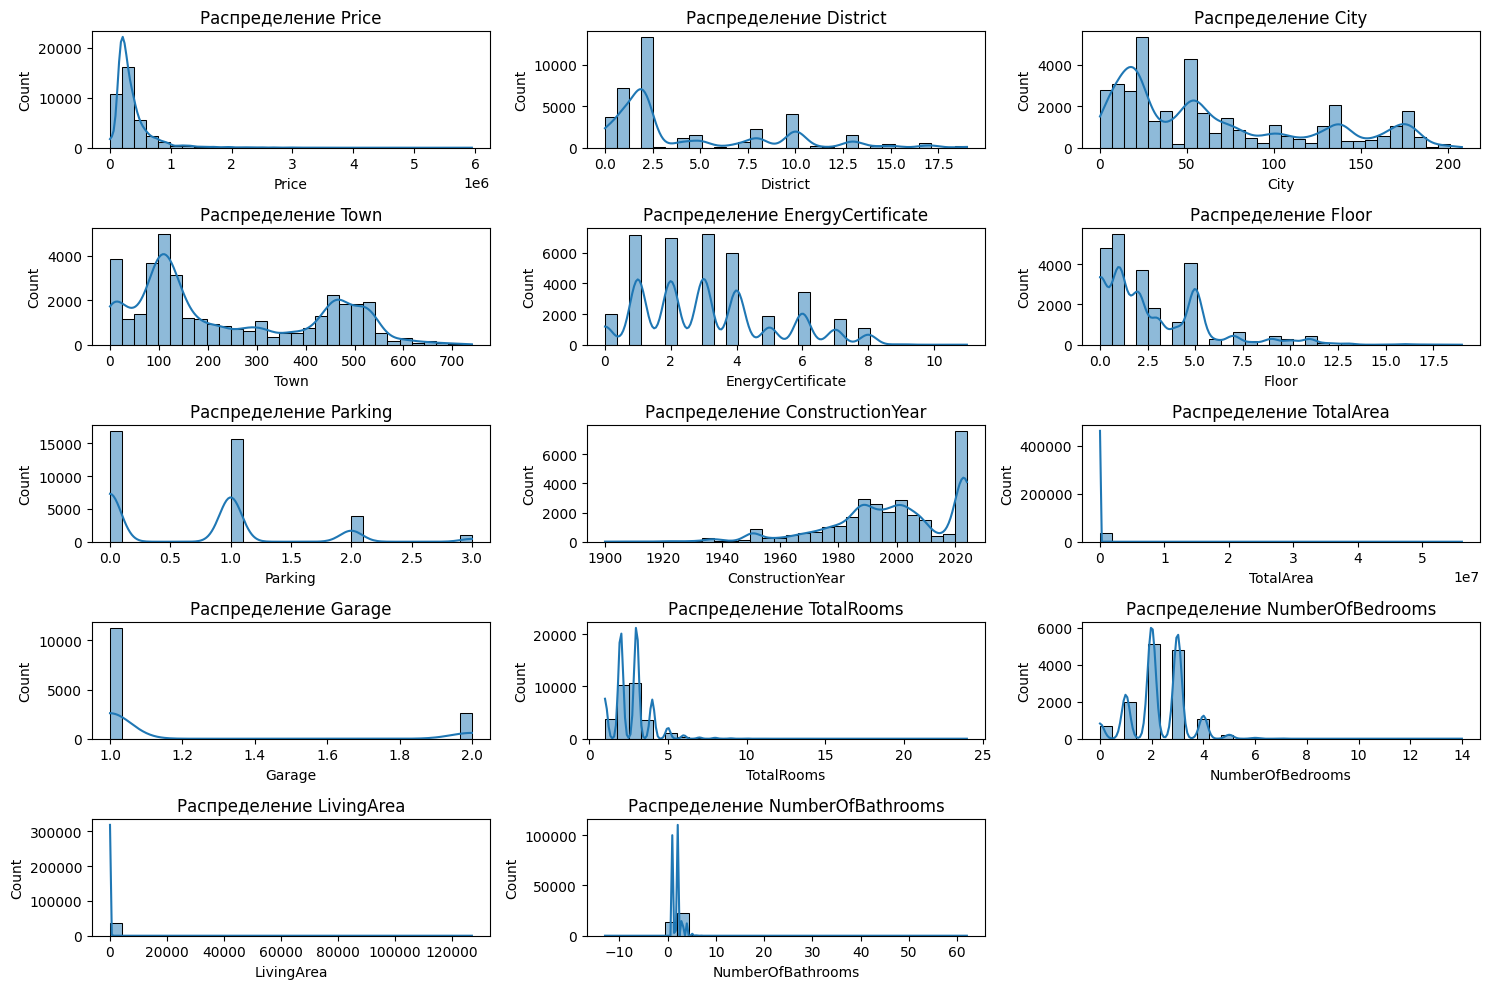

In [ ]:
# Графики распределения величин
numeric_features = dfu.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(dfu[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

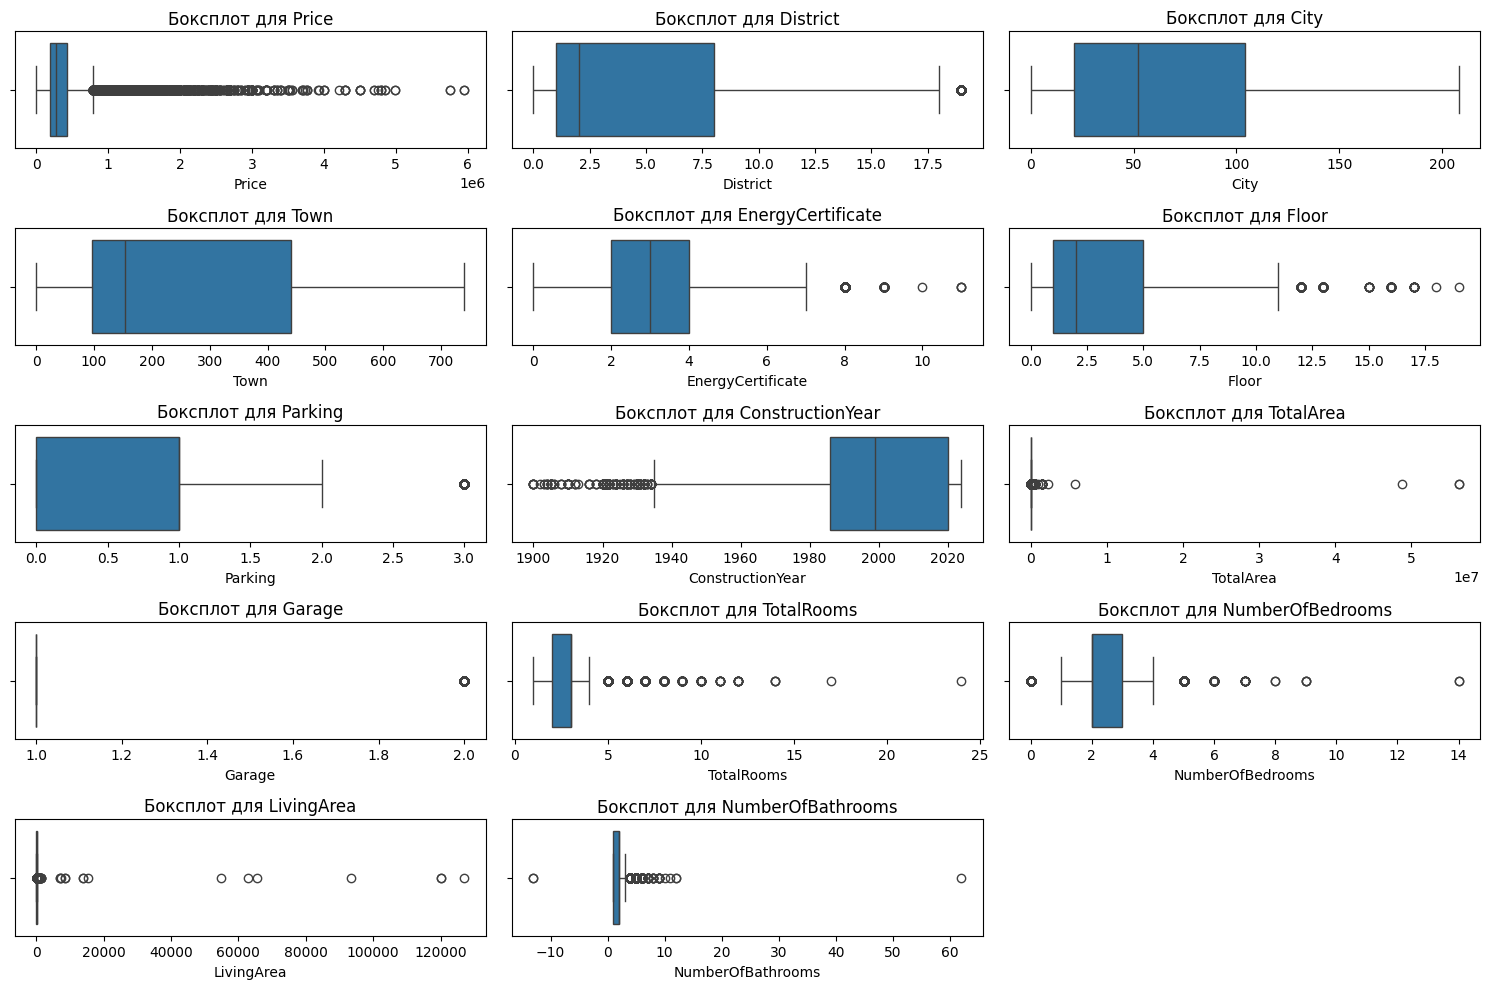

In [ ]:
# Ящики с усами
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(x=dfu[feature])
    plt.title(f'Боксплот для {feature}')
plt.tight_layout()
plt.show()

In [ ]:
dfu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37430 entries, 0 to 114489
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 37430 non-null  float64
 1   District              37430 non-null  int64  
 2   City                  37430 non-null  int64  
 3   Town                  37430 non-null  int64  
 4   EnergyCertificate     37430 non-null  int64  
 5   Floor                 23537 non-null  float64
 6   Parking               37411 non-null  float64
 7   HasParking            37430 non-null  bool   
 8   ConstructionYear      29638 non-null  float64
 9   TotalArea             36896 non-null  float64
 10  Garage                13868 non-null  float64
 11  ElectricCarsCharging  37430 non-null  bool   
 12  TotalRooms            29907 non-null  float64
 13  NumberOfBedrooms      13868 non-null  float64
 14  LivingArea            37377 non-null  float64
 15  NumberOfBathrooms     3

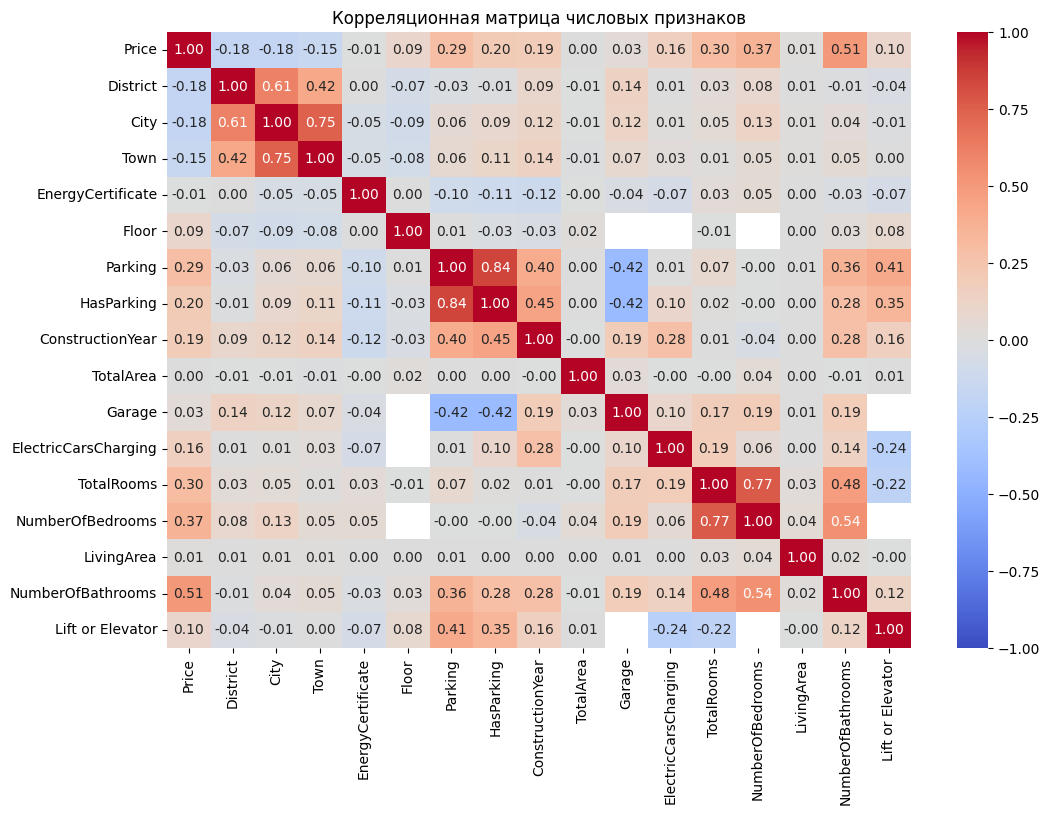

In [ ]:
# Корреляционная матрица
plt.figure(figsize=(12, 8))
correlation_matrix = dfu.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

#### 3.2.3 Удаление шума и ошибок ввода данных (df_without_noice)

На этом этапе происходит устранение шума и ошибок ввода данных, которые были обнаружены после анализа описательной характеристики и визуализации данных:

1.   Удаляются строки, в которых **NumberOfBathrooms**, **TotalArea** $<= 0$
2.   Удаляются строки, в которых **TotalArea** $<= 10$ и **LivingArea** $<= 5$
3.   Удаляются строки, в которых **NumberOfBathrooms** $> 50$ (1 из 37422) **TotalArea** $< 0$
4.   Удаляются строки, в которых **TotalArea** и **LivingArea** $> 3000$ (329 из 37421 - это < 0,9%)

In [ ]:
df_without_noice = dfu.copy(deep=True)

In [ ]:
#дропаем строки где площадь <11
#condition = (dfu["TotalArea"] < 11)

# Дропаем строки, удовлетворяющие условию
#dfu = dfu.drop(dfu[condition].index)

In [ ]:
# Дропаем строки, в которых значения 'NumberOfBathrooms', 'TotalArea' < 0
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["NumberOfBathrooms"] <= 0].index)
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["TotalArea"] <= 0].index)

In [ ]:
df_without_noice.describe()

,Price,District,City,Town,EnergyCertificate,Floor,Parking,ConstructionYear,TotalArea,Garage,TotalRooms,NumberOfBedrooms,LivingArea,NumberOfBathrooms
count,3.742200e+04,37422.000000,37422.000000,37422.000000,37422.000000,23533.000000,37403.000000,29635.000000,3.688800e+04,13864.000000,29899.000000,13864.000000,37369.000000,36097.000000
mean,3.760041e+05,4.174229,65.672973,240.698626,3.136631,2.785110,0.704863,1997.789337,5.650194e+03,1.186238,2.682464,2.309507,120.093045,1.898274
std,3.548465e+05,4.376285,55.983453,186.842479,2.021228,2.813456,0.757985,21.329680,4.875945e+05,0.389312,1.176783,1.054010,1326.644188,0.957115
min,8.750000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,1.000000e+00,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.900000e+05,1.000000,21.000000,96.000000,2.000000,1.000000,0.000000,1986.000000,7.700000e+01,1.000000,2.000000,2.000000,70.000000,1.000000
50%,2.750000e+05,2.000000,52.000000,154.000000,3.000000,2.000000,1.000000,1999.000000,1.030000e+02,1.000000,3.000000,2.000000,94.000000,2.000000
75%,4.300000e+05,8.000000,104.000000,440.000000,4.000000,5.000000,1.000000,2020.000000,1.390000e+02,1.000000,3.000000,3.000000,122.000000,2.000000
max,5.950000e+06,19.000000,208.000000,740.000000,11.000000,19.000000,3.000000,2024.000000,5.621510e+07,2.000000,24.000000,14.000000,127000.000000,62.000000


In [ ]:
len(df_without_noice[df_without_noice['TotalArea'] < 11])

11

In [ ]:
len(df_without_noice[df_without_noice["LivingArea"] < 6])

14

In [ ]:
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["TotalArea"] < 11].index)
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["LivingArea"] < 6].index)

In [ ]:
#Дропаем строки, в которых слишком большие значения 'NumberOfBathrooms', 'TotalArea', 'LivinArea'
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["NumberOfBathrooms"] > 50].index)
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["TotalArea"] > 3000].index)
df_without_noice = df_without_noice.drop(df_without_noice[df_without_noice["LivingArea"] > 3000].index)

In [ ]:
df_without_noice[df_without_noice['TotalArea'] < 11]

,Price,District,City,Town,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,TotalArea,Garage,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,LivingArea,NumberOfBathrooms,Lift or Elevator


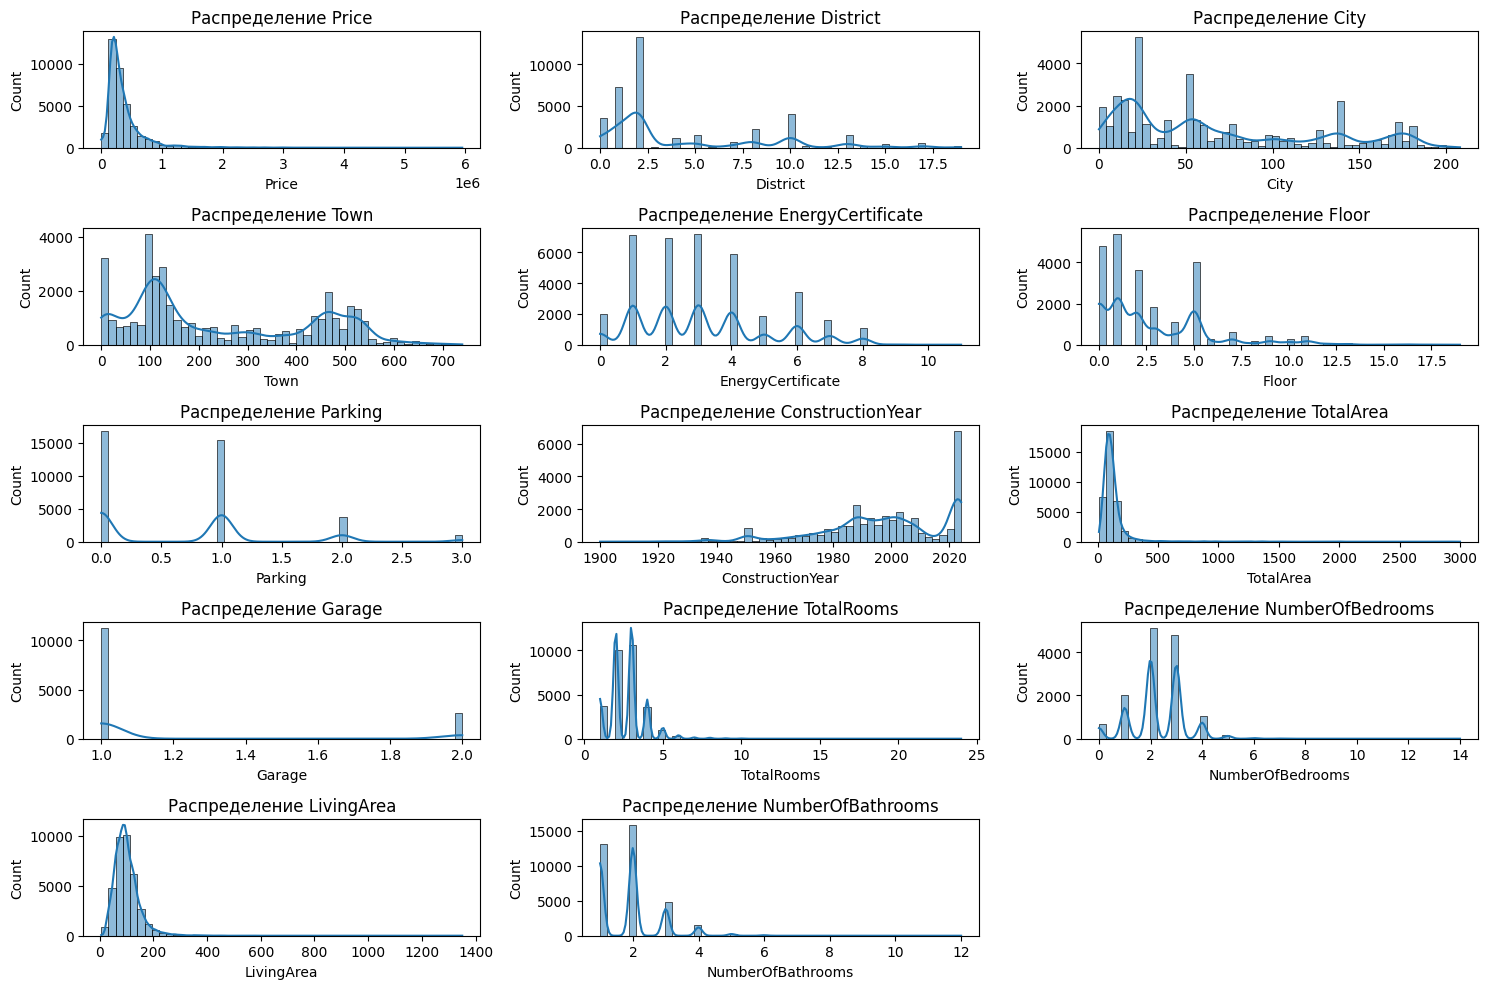

In [ ]:
# Графики распределения величин
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_without_noice[feature], kde=True, bins=50)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

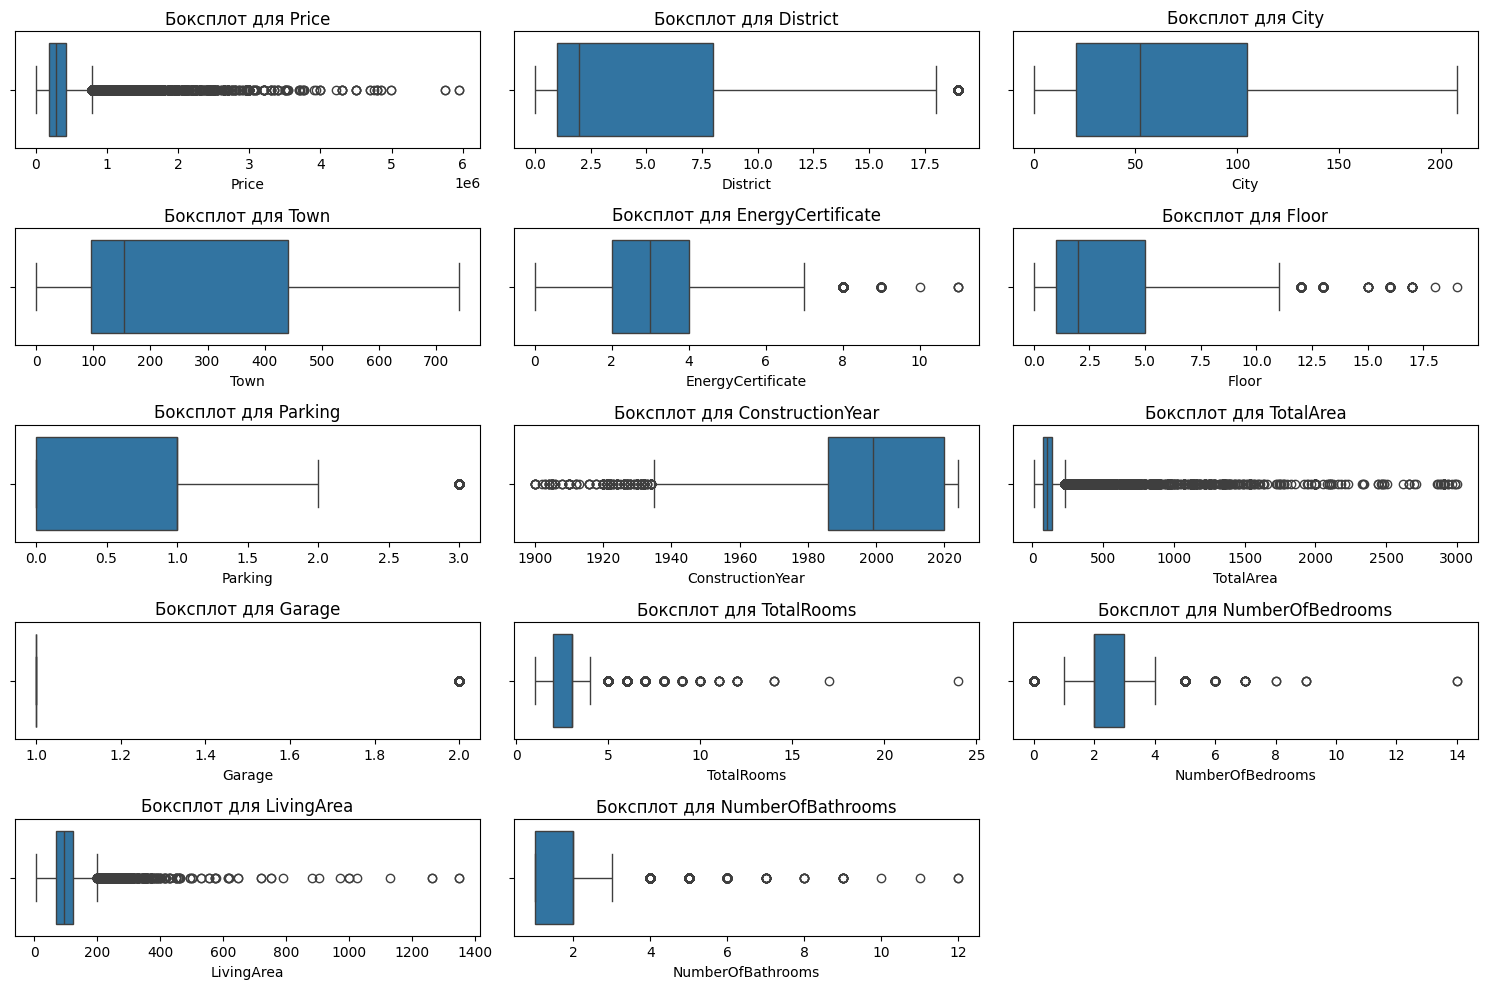

In [ ]:
# Ящики с усами
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(x=df_without_noice[feature])
    plt.title(f'Боксплот для {feature}')
plt.tight_layout()
plt.show()

#### 3.2.4 Преобразование переменных (df_transform)


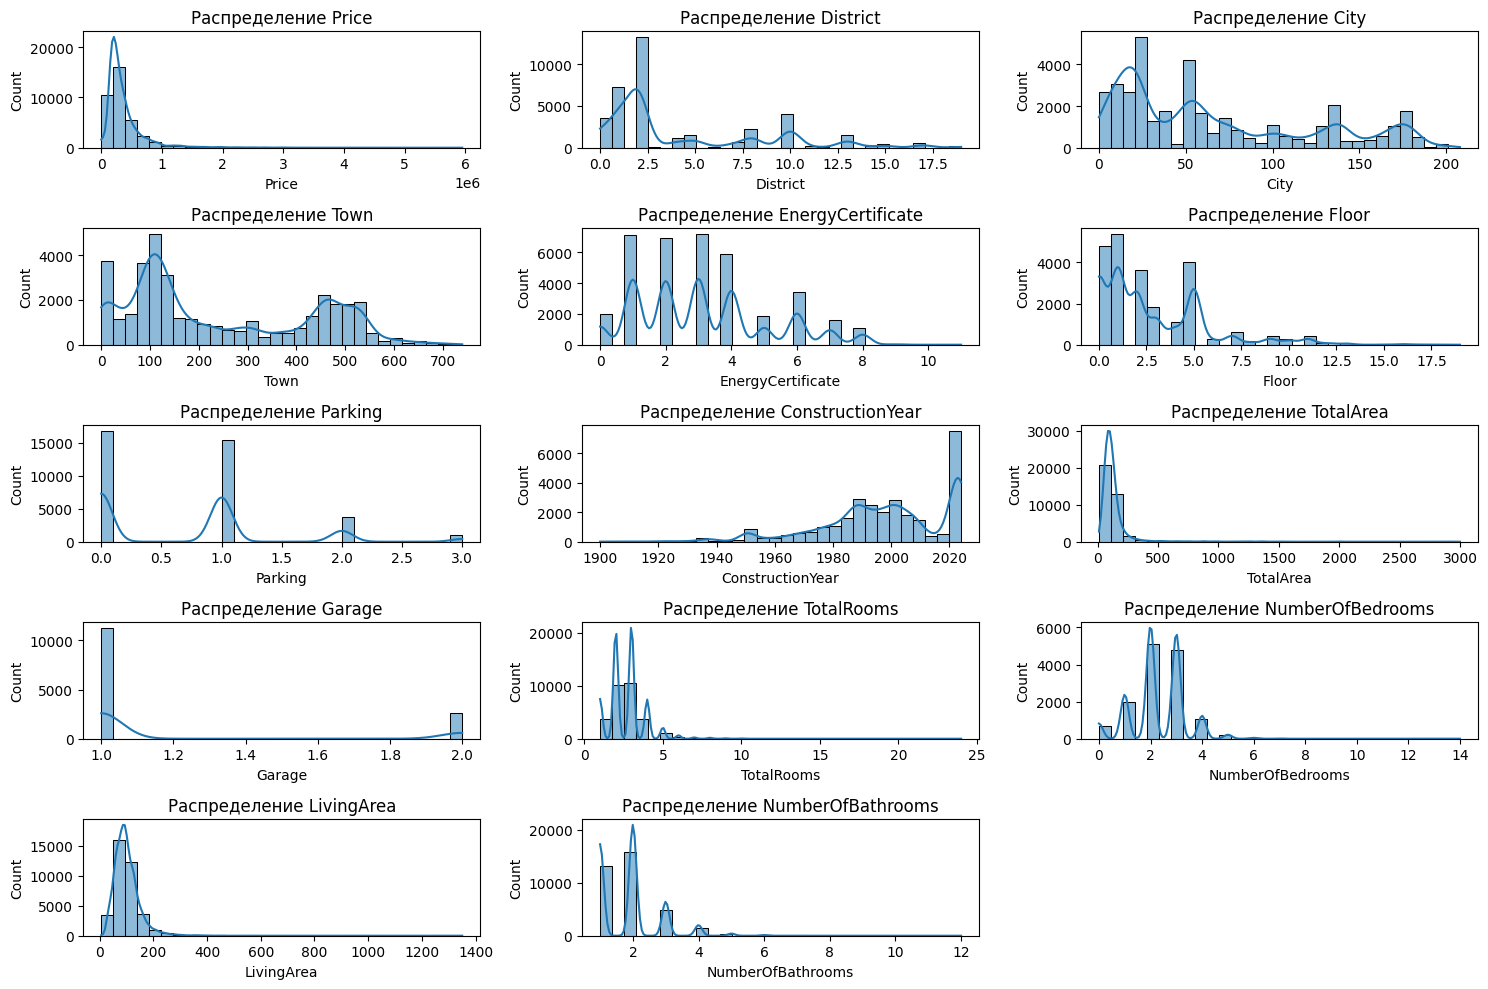

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_without_noice[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

##### sqrt

In [ ]:
df_transform_sqrt = df_without_noice.copy(deep=True)

In [ ]:
df_transform_sqrt['LivingArea'] = np.sqrt(df_transform_sqrt['LivingArea'])
df_transform_sqrt['TotalArea'] = np.sqrt(df_transform_sqrt['TotalArea'])


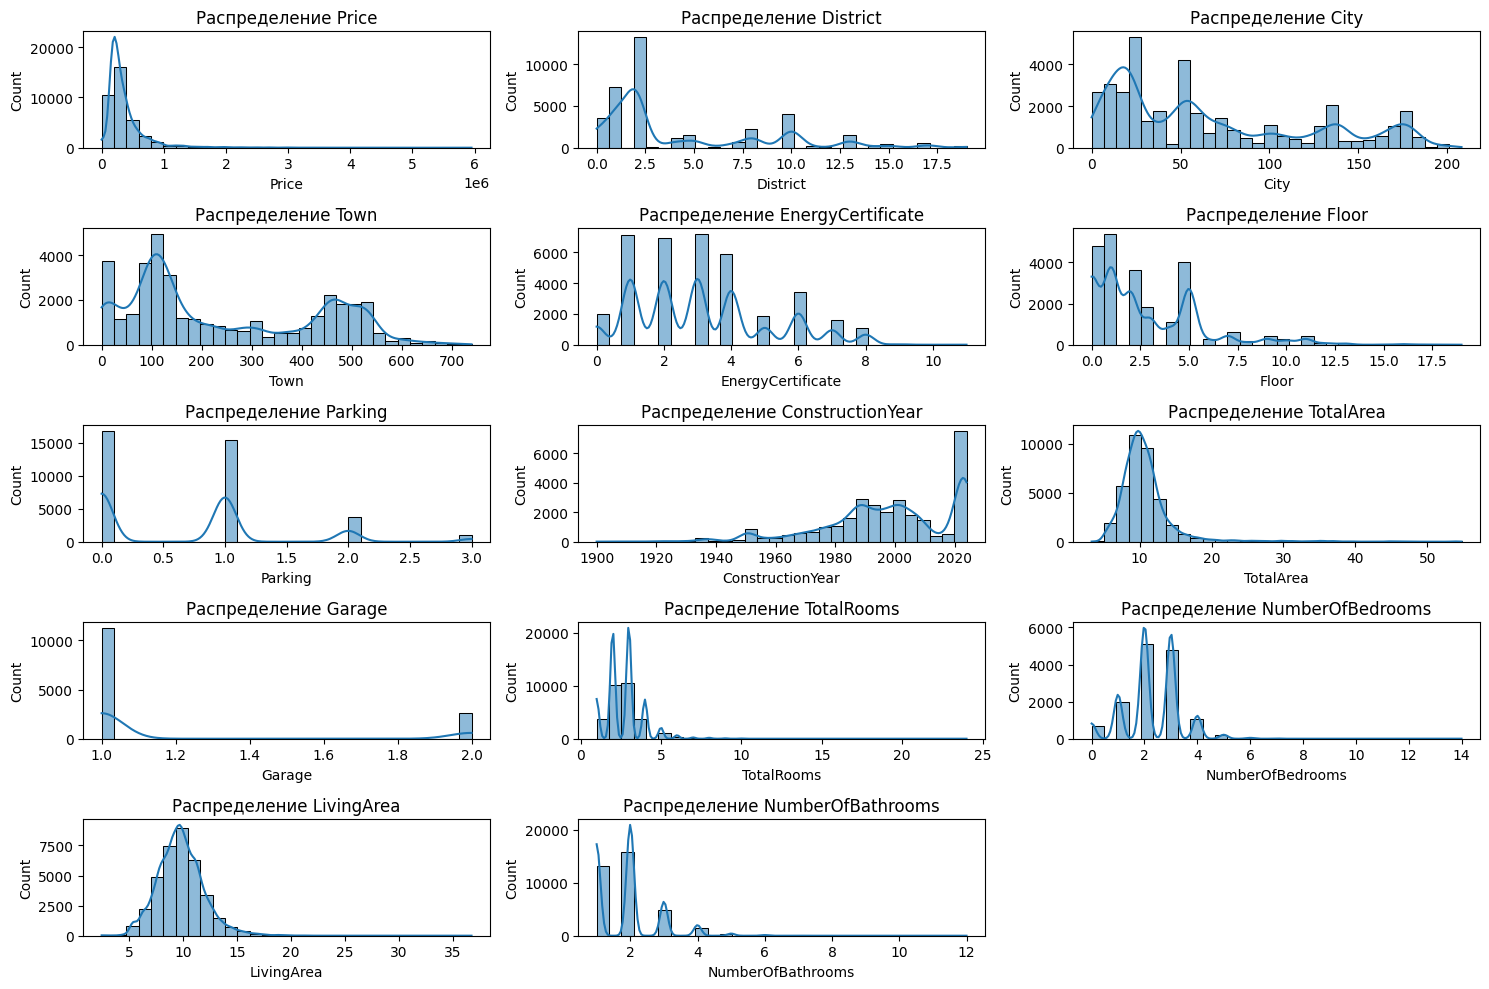

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_transform_sqrt[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

##### log

In [ ]:
df_transform_log = df_without_noice.copy(deep=True)

In [ ]:
df_transform_log['LivingArea'] = np.log(df_transform_log['LivingArea'])
df_transform_log['TotalArea'] = np.log(df_transform_log['TotalArea'])


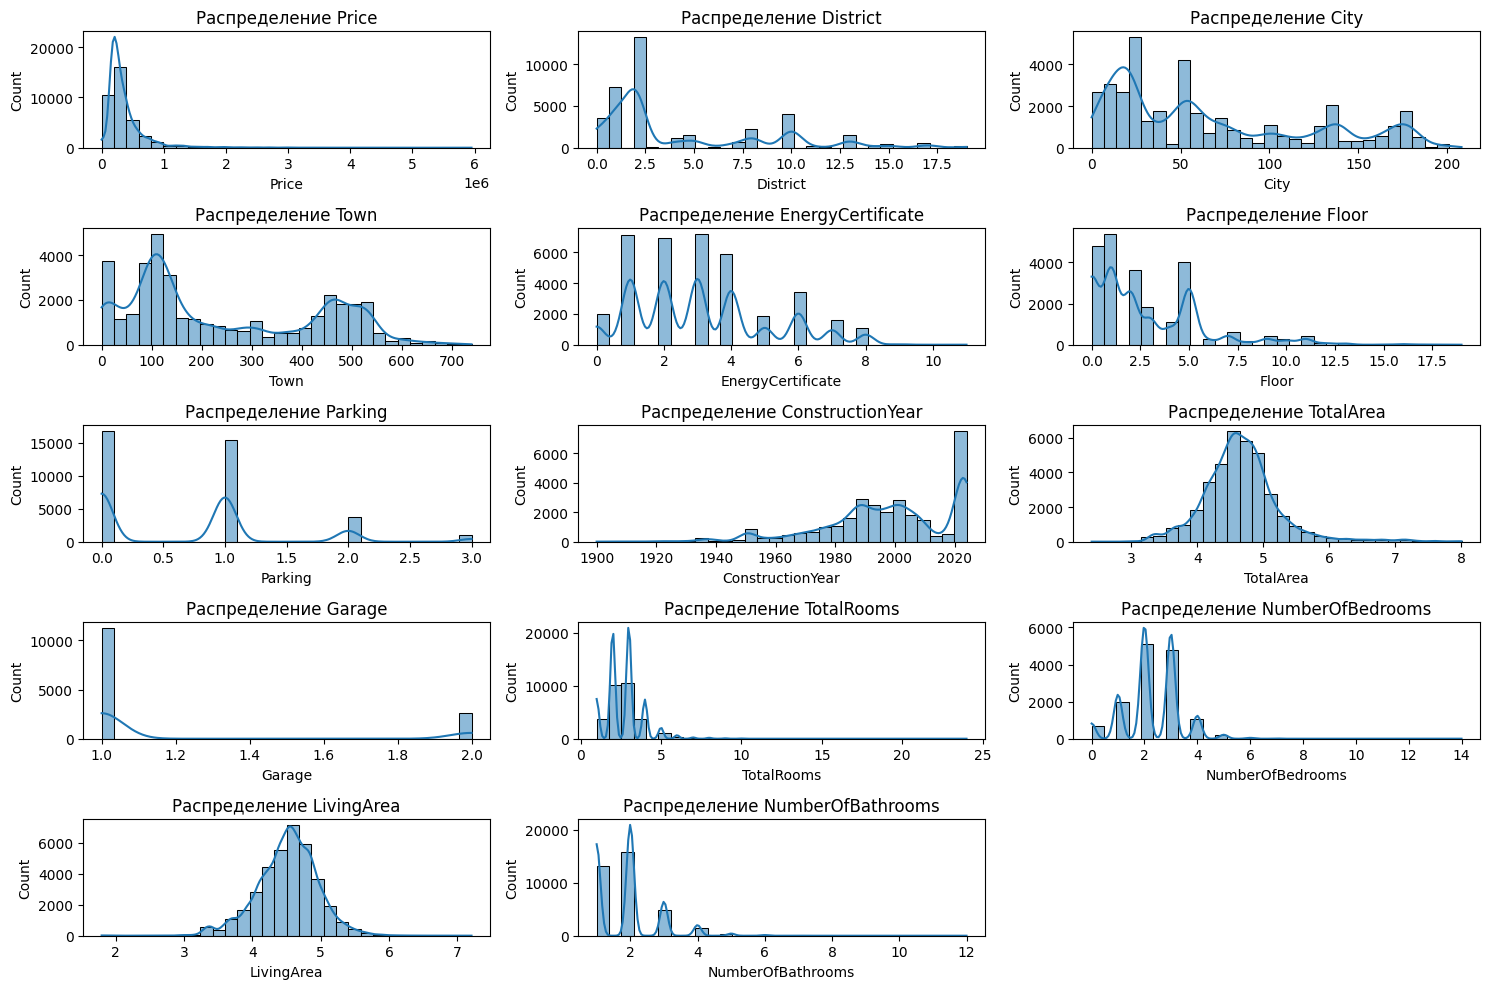

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_transform_log[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

In [ ]:
df_transform_BoxCox = df_without_noice.copy(deep=True)

#### 3.2.5 Масштабирование переменных (df_scale)

На этом этапе происходит масштабирование очищенных данных df_without_noice

In [ ]:
df_scale = df_without_noice.copy(deep=True)

In [ ]:
cols_except_price = [col for col in df_without_noice if col != 'Price']

# Создаем экземпляр StandardScaler
scaler = StandardScaler()

# Масштабируем данные
scaled_data = scaler.fit_transform(df_scale[cols_except_price])

# Преобразуем в DataFrame
df_scale = pd.DataFrame(scaled_data, columns = cols_except_price)
df_price = pd.DataFrame(df_without_noice['Price'], columns = ['Price'])
df_price = df_price.reset_index(drop=True)
df_scale.insert(0, 'Price', df_price)
df_scale

,Price,District,City,Town,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,TotalArea,Garage,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,LivingArea,NumberOfBathrooms,Lift or Elevator
0,250000.0,-0.955986,-1.177024,-1.292797,-1.550147,-0.988338,0.397765,0.912176,NaN,-0.119519,NaN,-0.287208,-0.581851,NaN,0.264608,0.11509,1.177341
1,9500.0,-0.955986,-1.159164,-1.287442,-1.054941,-0.633015,-0.927521,-1.096280,-0.362735,-0.627799,NaN,-0.287208,NaN,NaN,-1.474251,-0.99302,1.177341
2,580000.0,-0.955986,-1.141305,-1.282088,-0.559735,-0.277693,0.397765,0.912176,0.245553,-0.294788,NaN,-0.287208,-0.581851,NaN,-0.334998,0.11509,-0.849372
3,350000.0,-0.955986,-1.123446,-1.276733,-0.064528,0.077630,-0.927521,-1.096280,-0.596691,-0.388265,NaN,-0.287208,-0.581851,NaN,-0.654789,-0.99302,1.177341
4,1500000.0,-0.955986,-1.105586,-1.271379,0.430678,0.432952,3.048336,0.912176,0.947423,1.674065,NaN,-0.287208,3.661666,NaN,3.222668,NaN,1.177341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37054,155000.0,2.238615,0.912530,-0.810895,-1.550147,NaN,0.397765,0.912176,1.181379,-0.370738,-0.478121,-0.287208,1.115556,-0.293414,-0.594828,-0.99302,-0.849372
37055,195000.0,2.238615,0.912530,-0.810895,-1.550147,NaN,0.397765,0.912176,1.181379,-0.125361,-0.478121,-0.287208,2.812963,0.655404,0.244621,0.11509,-0.849372
37056,160000.0,2.238615,0.912530,-0.810895,-1.550147,NaN,0.397765,0.912176,1.181379,-0.370738,-0.478121,-0.287208,1.115556,-0.293414,-0.594828,-0.99302,-0.849372
37057,319000.0,-0.955986,-1.052008,-1.121454,1.421091,NaN,0.397765,0.912176,0.198761,-0.224680,-0.478121,-0.287208,0.266853,-0.293414,-0.694762,-0.99302,-0.849372


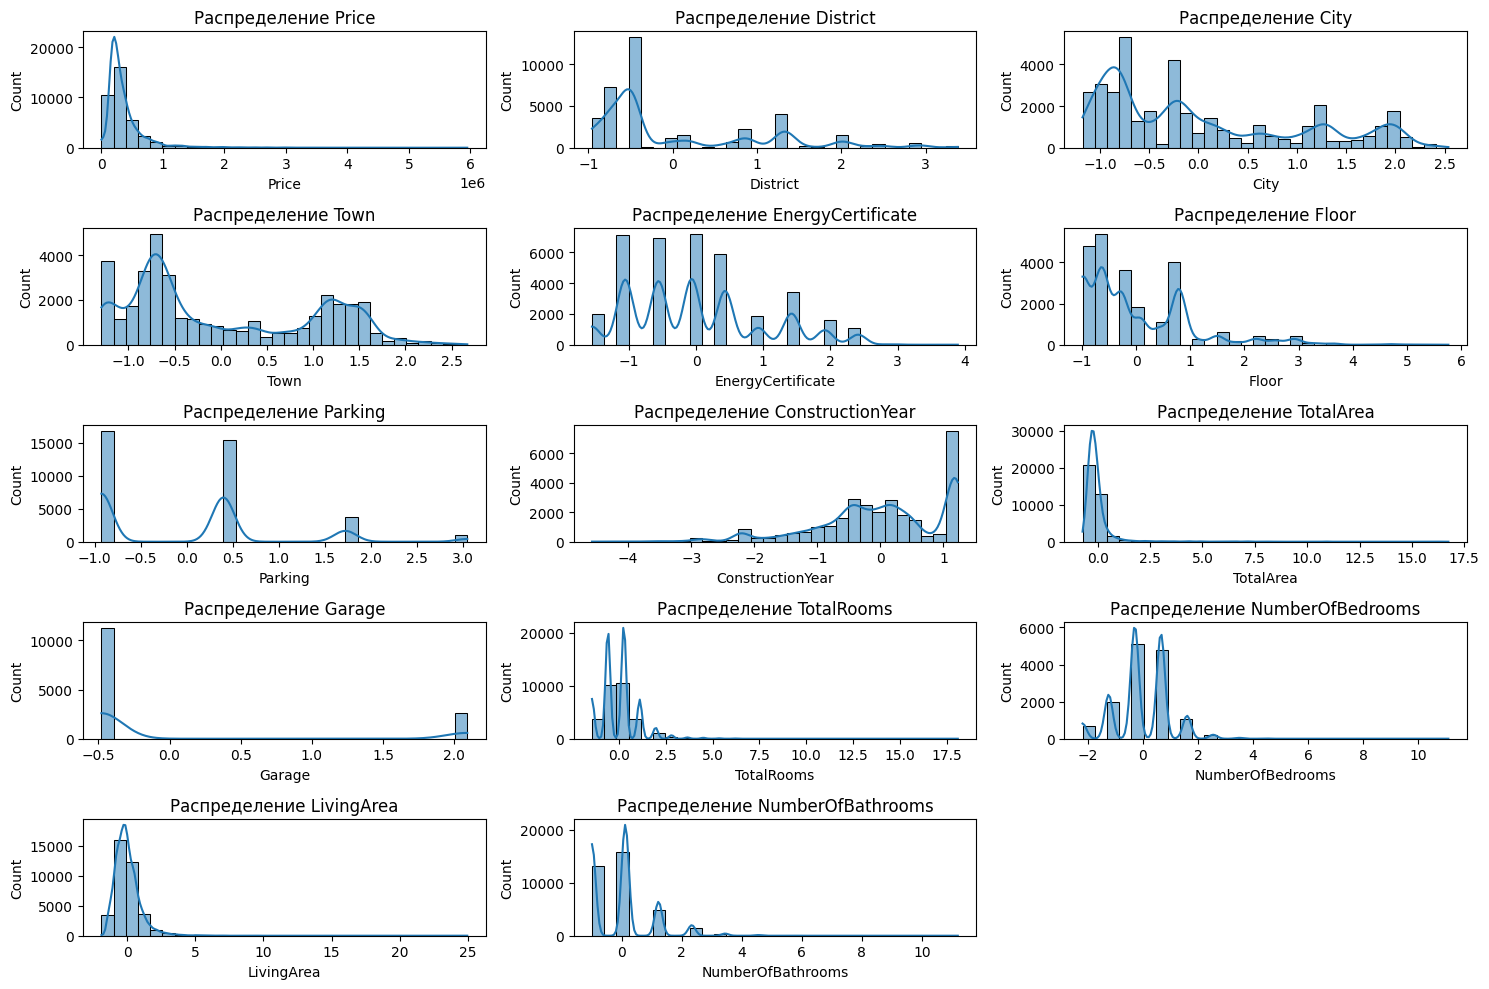

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df_scale[feature], kde=True, bins=30)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

#### 3.2.6 Обработка пропущенных значений (df_without_nans)

In [ ]:
# Найдем наиболее подходящую стратегию работы с NaN
df_without_nans = df_scale.copy(deep=True)

##### Количество NaN

In [ ]:
# Количество NaN
df_without_nans.isnull().sum()

,0
Price,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,13862
Parking,9
HasParking,0
ConstructionYear,7671
TotalArea,534


In [ ]:
# Процентное соотношение NaN
100 * df_without_nans.isnull().sum() / len(df_without_nans)

,0
Price,0.000000
District,0.000000
City,0.000000
Town,0.000000
EnergyCertificate,0.000000
Floor,37.405219
Parking,0.024286
HasParking,0.000000
ConstructionYear,20.699425
TotalArea,1.440946


<ipython-input-220-56988b95402b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percent_nan.index,y=percent_nan, palette='flare', legend=False)


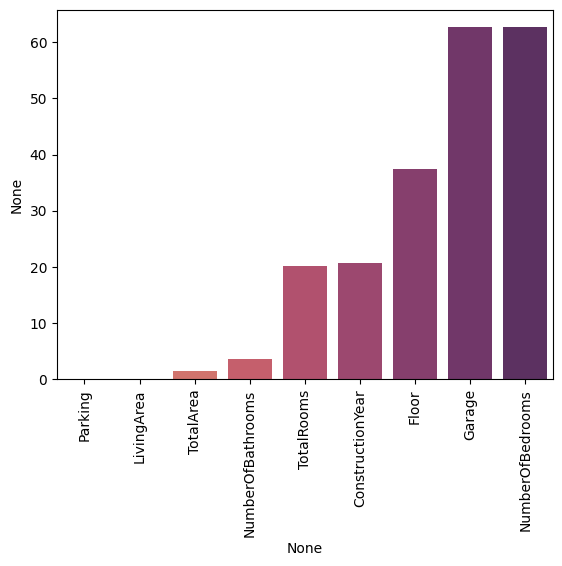

In [ ]:
# Визуализируем отсутствующие данные
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan


percent_nan = percent_missing(df_without_nans)

sns.barplot(x=percent_nan.index,y=percent_nan, palette='flare', legend=False)
plt.xticks(rotation=90);

##### Remove method

In [ ]:
df_without_nans_remove = df_without_nans.copy(deep=True)

In [ ]:
# Количество NaN-значений
df_without_nans_remove.isna().sum()

,0
Price,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,13862
Parking,9
HasParking,0
ConstructionYear,7671
TotalArea,534


In [ ]:
# Очистим строки с NaN и посмотрим количество оставшихся строк
df_without_nans_remove.dropna(inplace=True)
print(df_without_nans_remove.shape)

(0, 17)


Как мы можем видеть, удаление NaN-значений невозможен для дальнейшего использования из-за полной очистки датасета (количество строк = 0). Следовательно, данный метод в дальнейшем не используется.

##### Median method

In [ ]:
# Перекодируем остальные признаки, имеющие числовые значения
columns_with_nan = [column for column in df_without_nans.columns \
                                  if df_without_nans[column].isna().any()]

df_without_nans_median = df_without_nans.copy(deep=True)

for column in columns_with_nan:
    median_value = df_without_nans_median[column].median()
    df_without_nans_median[column].fillna(median_value, inplace=True)

<ipython-input-224-1ac2ad44390a>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_without_nans_median[column].fillna(median_value, inplace=True)


In [ ]:
# Проверим результат заполнения
df_without_nans_median.isna().sum()

,0
Price,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,0
Parking,0
HasParking,0
ConstructionYear,0
TotalArea,0


In [ ]:
X = df_without_nans_median.drop('Price', axis=1)
y = df_without_nans_median.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr_without_nans_median = LinearRegression()
lr_without_nans_median.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr_without_nans_median.predict(X_test)

In [ ]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred, squared=False))

0.40232946165492145
263402.9749371421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### Mean method

In [ ]:
# Перекодируем остальные признаки, имеющие числовые значения
columns_with_nan = [column for column in df_without_nans.columns \
                                  if df_without_nans[column].isna().any()]

df_without_nans_mean = df_without_nans.copy(deep=True)

for column in columns_with_nan:
    median_value = df_without_nans_mean[column].mean()
    df_without_nans_mean[column].fillna(median_value, inplace=True)

<ipython-input-230-6cf83b69a49f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_without_nans_mean[column].fillna(median_value, inplace=True)


In [ ]:
# Проверим результат заполнения
df_without_nans_mean.isna().sum()

,0
Price,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,0
Parking,0
HasParking,0
ConstructionYear,0
TotalArea,0


In [ ]:
X = df_without_nans_mean.drop('Price', axis=1)
y = df_without_nans_mean.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr_without_nans_mean = LinearRegression()
lr_without_nans_mean.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr_without_nans_mean.predict(X_test)

print(f"R^2 score: {r2_score(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}");

R^2 score: 0.403750936438554
MSE: 263089.55512257846


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##### Промежуточный вывод

In [ ]:
#- При заменене NaN **медианой**:
#
#  - Критерий R$^2$ = 0.402
 # - MSE = 263403

#- При заменене NaN **средним**:

#  - Критерий R$^2$ = 0.404
#  - MSE = 263090


- При удалении NaN-значений происходит обнуление количества строк в датасете.

В качестве базового метода обработки NaN-значений выберем заполнением **средними значениями**.

In [ ]:
# В дальнейшем работаем с датасетом df_without_nans_mean
df_without_nans = df_without_nans_mean.copy(deep=True)

#### 3.2.7 Обнаружение и устранение отклонений

Работаем только с непрерывными переменными - `TotalArea`, `LivingArea`.

##### 3.2.7. Обнаружение отклонений - IQR

In [ ]:
df_numeric = df_without_nans.select_dtypes(include=['float', 'int'])
df_price = df_numeric['Price']
df_numeric = df_numeric.drop('Price', axis=1)
# Рассчитываем квартильные значения и IQR
Q1 = df_numeric.quantile(0.15)
Q3 = df_numeric.quantile(0.85)

IQR = Q3 - Q1

In [ ]:
# Выполним замену на NaN
columns = ['TotalArea', 'LivingArea']

def replace_with_nan_iqr(df, columns):
    df_result = df.copy(deep=True)

    for col in columns:
        Q1 = df_result[col].quantile(0.25)
        Q3 = df_result[col].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_result[col] = df_result[col].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    return df_result

df_mean_outliers = replace_with_nan_iqr(df_numeric, columns)

In [ ]:
# Выполним замену на среднее
def replace_with_mean(df):
    # Выберем все признаки с NaN
    columns_with_nan = [column for column in df.columns \
                        if df[column].isna().any()]

    # Выполним замену
    for column in columns_with_nan:
        median_value = df[column].mean()
        df[column].fillna(median_value, inplace=True)

replace_with_mean(df_mean_outliers)

<ipython-input-239-80e5631d9e7d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


In [ ]:
# Проверим, что нет NaN-значений
df_mean_outliers.isna().sum()

,0
District,0
City,0
Town,0
EnergyCertificate,0
Floor,0
Parking,0
HasParking,0
ConstructionYear,0
TotalArea,0
Garage,0


##### 3.2.7. Обнаружение отклонений - Z1-Score

In [ ]:
df_zscore = df_without_nans.copy(deep=True)

# Копируем DataFrame
df_zscore = df_without_nans.copy(deep=True)

 #Убираем столбец 'Price' (если это требуется)
if 'Price' in df_zscore.columns:
     df_zscore = df_zscore.drop(columns=['Price'])

# Вычисляем Z-оценки
z_scores = df_zscore.apply(zscore)

# Установим порог для определения выбросов (обычно используется |z| > 3)
threshold = 8

# Определяем выбросы
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Создаем DataFrame с заменой выбросов на NaN
df_zscore_nan = df_zscore.mask(outliers)

# Рассчитаем 10% и 90% квантиль для каждого столбца
quantiles_10 = df_zscore.quantile(0.05)
quantiles_90 = df_zscore.quantile(0.95)

# Функция замены выбросов на соответствующие квантили
def replace_outliers_with_quantiles(row, outlier_row):
    for col in row.index:
        if outlier_row[col]:  # Если это выброс
            if row[col] > quantiles_90[col]:  # Выброс больше 90%
                row[col] = quantiles_90[col]
            elif row[col] < quantiles_10[col]:  # Выброс меньше 10%
                row[col] = quantiles_10[col]
    return row

# Применяем функцию ко всем строкам для замены выбросов
df_zscore_kvant = df_zscore.copy()
df_zscore_kvant = df_zscore_kvant.apply(
    lambda row: replace_outliers_with_quantiles(row, outliers.loc[row.name]), axis=1
)

# Результаты:
# - df_zscore_nan: выбросы заменены на NaN
# - df_zscore_kvant: выбросы заменены на квантили 10% и 90% перепиши этот код так, чтобы он работал только с двумя столбцами из df-score под названием TotalArea, LivingArea# # # Копируем DataFrame
# df_zscore = df_without_nans.copy(deep=True)

# # Оставляем только интересующие нас столбцы
# columns_of_interest = ['TotalArea', 'LivingArea']
# df_selected = df_zscore[columns_of_interest]

# # Вычисляем Z-оценки только для указанных столбцов
# z_scores = df_selected.apply(zscore)

# # Установим порог для определения выбросов (например, |z| > 10)
# threshold = 8

# # Определяем выбросы
# outliers = (z_scores > threshold) | (z_scores < -threshold)

# # Создаем DataFrame с заменой выбросов на NaN
# df_selected_nan = df_selected.mask(outliers)

# # Рассчитаем 10% и 90% квантиль для каждого столбца
# quantiles_10 = df_selected.quantile(0.1)
# quantiles_90 = df_selected.quantile(0.90)

# # Функция замены выбросов на соответствующие квантили
# def replace_outliers_with_quantiles(row, outlier_row):
#     for col in row.index:
#         if outlier_row[col]:  # Если это выброс
#             if row[col] > quantiles_90[col]:  # Выброс больше 90%
#                 row[col] = quantiles_90[col]
#             elif row[col] < quantiles_10[col]:  # Выброс меньше 10%
#                 row[col] = quantiles_10[col]
#     return row

# # Применяем функцию ко всем строкам для замены выбросов
# df_selected_kvant = df_selected.copy()
# df_selected_kvant = df_selected_kvant.apply(
#     lambda row: replace_outliers_with_quantiles(row, outliers.loc[row.name]), axis=1
# )

# # Возвращаем обработанные столбцы в исходный DataFrame
# df_zscore_nan = df_zscore.copy()
# df_zscore_kvant = df_zscore.copy()

# df_zscore_nan[columns_of_interest] = df_selected_nan
# df_zscore_kvant[columns_of_interest] = df_selected_kvant

# # Итоговые результаты:
# # - df_zscore_nan: DataFrame с выбросами, замененными на NaN, только в столбцах 'TotalArea' и 'LivingArea'
# # - df_zscore_kvant: DataFrame с выбросами, замененными на квантили 10% и 90%, в тех же столбцах


In [ ]:
df_zscore_kvant = df_zscore_kvant.join(df_price)


In [ ]:
# numeric_features = df_zscore_kvant.select_dtypes(include=['float64', 'int64']).columns

# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(numeric_features):
#     plt.subplot(5, 4, i + 1)
#     sns.histplot(df_zscore_kvant[feature], kde=True, bins=30)
#     plt.title(f'Распределение {feature}')
# plt.tight_layout()
# plt.show()

In [ ]:
X = df_zscore_kvant.drop('Price', axis=1)
y = df_zscore_kvant.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr_noize = LinearRegression()
lr_noize.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_noize = lr_noize.predict(X_test)

In [ ]:
print(r2_score(y_test, y_noize))

0.4105194005311513


##### 3.2.7 Устранение

Whether an outlier should be removed or not. Every data analyst/data scientist might get these thoughts once in every problem they are working on. I have found some good explanations -

https://www.researchgate.net/post/When_is_it_justifiable_to_exclude_outlier_data_points_from_statistical_analyses

https://www.researchgate.net/post/Which_is_the_best_method_for_removing_outliers_in_a_data_set

https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

##### Промежуточный вывод

##4. Повторное обучение

###4.1 Обучение модели линейной регрессии на обработанных данных и оценка показателей эффективности R-square, RMSE

Обучим модель на очищенном от выбросов датасете

In [ ]:
Z = .copy(deep=True)

SyntaxError: invalid syntax (<ipython-input-248-c35fd29b00de>, line 1)

In [ ]:
X = Z.drop('Price', axis=1)
y = Z.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred, squared=False))

###4.2 Обучение модели CatBoost на обработанных данных ради интереса и оценка показателей эффективности R-square, RMSE